In [ ]:
!fusermount -u /content/drive
from google.colab import drive
drive.mount('/content/drive')


fusermount: failed to unmount /content/drive: Invalid argument


ValueError: Mountpoint must not already contain files

In [ ]:
import os

TRAIN_DIR = "/content/drive/MyDrive/DBI/train"
VAL_DIR = "/content/drive/MyDrive/DBI/val"

print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Val dir exists:", os.path.exists(VAL_DIR))


Train dir exists: False
Val dir exists: False


In [ ]:
# ================================================================
# DBI (Dog Breed Identification) — EfficientNetB3 + Lite ViT head
# - Dataset: /content/drive/MyDrive/DBI/train (subfolders=classes)
# - Uses validation_split (no separate val folder needed)
# - Mixed precision for T4, sparse labels so class_weight works
# - ViT-ish transformer head on top of CNN features
# ================================================================

import os, sys, glob, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers

# ----------------- CONFIG -----------------
DRIVE_BASE = "/content/drive/MyDrive/DBI"
TRAIN_DIR  = f"{DRIVE_BASE}/train"
TEST_DIR   = f"{DRIVE_BASE}/test"           # optional
CHECKPOINT_DIR = f"{DRIVE_BASE}/checkpoints"
FINAL_MODEL_PATH = f"{DRIVE_BASE}/dbi_efficientvit_final.keras"
SUBMISSION_OUT   = f"{DRIVE_BASE}/submission.csv"
SAMPLE_SUB_CSV   = f"{DRIVE_BASE}/sample_submission.csv"  # optional

USE_LOCAL_COPY = False    # set True if Drive I/O is too slow
IMAGE_SIZE = 224
BATCH_SIZE = 12
VAL_SPLIT  = 0.20
SEED       = 1337
HEAD_EPOCHS = 4
FT_EPOCHS   = 8
BACKBONE_NAME = "B3"      # fallback to "B0" if OOM

# Transformer (lite) settings
TRANSFORMER_DEPTH = 2
MH_HEADS = 6
TOKEN_DIM = 384
MLP_RATIO = 2
DROPOUT = 0.2

# ----------------- Env Print -----------------
print("Python:", sys.version.splitlines()[0])
print("TF:", tf.__version__, "NumPy:", np.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------- Drive Mount -----------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print("Drive mount skipped:", e)

if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"TRAIN_DIR not found: {TRAIN_DIR}")

# ----------------- Local Copy Option -----------------
LOCAL_BASE = "/content/DBI_local"
LOCAL_TRAIN = f"{LOCAL_BASE}/train"
LOCAL_TEST  = f"{LOCAL_BASE}/test"

if USE_LOCAL_COPY:
    if not os.path.exists(LOCAL_TRAIN):
        print("Copying train to /content (first run only)...")
        os.makedirs(LOCAL_BASE, exist_ok=True)
        shutil.copytree(TRAIN_DIR, LOCAL_TRAIN)
    if os.path.isdir(TEST_DIR) and not os.path.exists(LOCAL_TEST):
        print("Copying test to /content (optional)...")
        shutil.copytree(TEST_DIR, LOCAL_TEST)
    DATA_TRAIN_DIR = LOCAL_TRAIN
    DATA_TEST_DIR  = LOCAL_TEST if os.path.isdir(TEST_DIR) else TEST_DIR
else:
    DATA_TRAIN_DIR = TRAIN_DIR
    DATA_TEST_DIR  = TEST_DIR

print("Using train dir:", DATA_TRAIN_DIR)

# ----------------- tf.data Datasets -----------------
tf.random.set_seed(SEED)
np.random.seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    validation_split=VAL_SPLIT,
    subset='training',
    seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    validation_split=VAL_SPLIT,
    subset='validation',
    seed=SEED
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Detected classes:", NUM_CLASSES)

# ----------------- Aug & Norm -----------------
normalization = layers.Rescaling(1./255)
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06),
    layers.RandomContrast(0.06),
])

def map_train(x, y):
    return augmentation(normalization(x), training=True), y
def map_val(x, y):
    return normalization(x), y

train_ds = train_ds.map(map_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(map_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# ----------------- Class Weights -----------------
counts = [len(glob.glob(os.path.join(DATA_TRAIN_DIR, c, "*.jpg"))) for c in class_names]
counts = np.array(counts)
class_weight = {i: (counts.sum() / (len(counts) * counts[i])) for i in range(len(counts))}
print("Class weight sample:", list(class_weight.items())[:5])

# ----------------- Mixed Precision -----------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision:", mixed_precision.global_policy())

# ----------------- Backbone -----------------
def get_backbone(name="B3", image_size=IMAGE_SIZE):
    try:
        if name == "B3":
            return tf.keras.applications.EfficientNetB3(
                include_top=False, weights='imagenet',
                input_shape=(image_size, image_size, 3)
            )
        else:
            return tf.keras.applications.EfficientNetB0(
                include_top=False, weights='imagenet',
                input_shape=(image_size, image_size, 3)
            )
    except:
        return tf.keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet',
            input_shape=(image_size, image_size, 3)
        )

# ----------------- Transformer Encoder -----------------
def transformer_encoder(x, num_heads=MH_HEADS, key_dim=64, mlp_dim=None, drop=DROPOUT):
    if mlp_dim is None:
        mlp_dim = key_dim * MLP_RATIO
    ln1 = layers.LayerNormalization(epsilon=1e-6, dtype='float32')(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=drop)(ln1, ln1)
    x = layers.Add()([x, attn])
    ln2 = layers.LayerNormalization(epsilon=1e-6, dtype='float32')(x)
    mlp = layers.Dense(mlp_dim, activation='gelu')(ln2)
    mlp = layers.Dropout(drop)(mlp)
    mlp = layers.Dense(x.shape[-1])(mlp)
    return layers.Add()([x, mlp])

# ----------------- Build Model -----------------
def build_model(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME):
    base = get_backbone(backbone_name)
    base.trainable = False
    inp = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    feat = base(inp, training=False)  # [B,H,W,C]
    feat = layers.Conv2D(TOKEN_DIM, 1)(feat)
    H, W, C = feat.shape[1], feat.shape[2], feat.shape[3]
    tokens = layers.Reshape((H*W, C))(feat)
    pos_embed = tf.Variable(tf.random.normal([1, H*W, C], stddev=0.02),
                            trainable=True, name="pos_embed")
    tokens = layers.Add()([tokens, pos_embed])
    x = tokens
    for _ in range(TRANSFORMER_DEPTH):
        x = transformer_encoder(x, num_heads=MH_HEADS, key_dim=C//MH_HEADS, mlp_dim=C*MLP_RATIO)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    logits = layers.Dense(num_classes)(x)
    out = layers.Activation('softmax', dtype='float32')(logits)
    return models.Model(inp, out), base

model, backbone = build_model()
model.summary()

# ----------------- Train -----------------
loss = tf.keras.losses.SparseCategoricalCrossentropy()
opt  = optimizers.Adam(1e-3)
model.compile(optimizer=opt, loss=loss, metrics=['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

print("\n=== Stage 1: head training ===")
model.fit(train_ds, validation_data=val_ds, epochs=HEAD_EPOCHS, class_weight=class_weight, verbose=1)

print("\n=== Stage 2: fine-tuning ===")
backbone.trainable = True
for l in backbone.layers[:int(len(backbone.layers)*0.6)]:
    l.trainable = False
model.compile(optimizer=optimizers.Adam(1e-5), loss=loss, metrics=['acc','top_k_categorical_accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=FT_EPOCHS, class_weight=class_weight, verbose=1)

# ----------------- Save -----------------
print("Saving model to:", FINAL_MODEL_PATH)
model.save(FINAL_MODEL_PATH)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TF: 2.19.0 NumPy: 2.0.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive
Using train dir: /content/drive/MyDrive/DBI/train
Found 10222 files belonging to 120 classes.
Using 8178 files for training.
Found 10222 files belonging to 120 classes.
Using 2044 files for validation.
Detected classes: 120
Class weight sample: [(0, np.float64(1.0647916666666666)), (1, np.float64(0.7343390804597701)), (2, np.float64(0.9905038759689923)), (3, np.float64(0.7961059190031152)), (4, np.float64(1.151126126126126))]
Mixed precision: <DTypePolicy "mixed_float16">


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ input_layer_2[0]… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 384) │    590,208 │ efficientnetb3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 384)   │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 49, 384)      │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 49, 384)      │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 49, 384)      │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 49, 384)      │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 49, 384)      │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (1, 49, 768)      │    295,680 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (1, 49, 768)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, 49, 384)      │    295,296 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 49, 384)      │          0 │ add_1[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 49, 384)      │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 49, 384)      │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (1, 49, 384)      │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 49, 384)      │        768 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, 49, 768)      │    295,680 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (1, 49, 768)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,000,167 (53.41 MB)

 Trainable params: 3,216,632 (12.27 MB)

 Non-trainable params: 10,783,535 (41.14 MB)


=== Stage 1: head training ===
Epoch 1/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - acc: 0.0059 - loss: 5.0520 - sparse_top_k_categorical_accuracy: 0.0195 - val_acc: 0.0391 - val_loss: 4.7871 - val_sparse_top_k_categorical_accuracy: 0.0401
Epoch 2/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 139s 203ms/step - acc: 0.0086 - loss: 4.7983 - sparse_top_k_categorical_accuracy: 0.0246 - val_acc: 0.0523 - val_loss: 4.7843 - val_sparse_top_k_categorical_accuracy: 0.0988
Epoch 3/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 141s 206ms/step - acc: 0.0079 - loss: 4.7907 - sparse_top_k_categorical_accuracy: 0.0243 - val_acc: 0.0523 - val_loss: 4.7841 - val_sparse_top_k_categorical_accuracy: 0.0988
Epoch 4/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 138s 203ms/step - acc: 0.0096 - loss: 4.7921 - sparse_top_k_categorical_accuracy: 0.0251 - val_acc: 0.0000e+00 - val_loss: 4.7842 - val_sparse_top_k_categorical_accuracy: 0.0988

=== Stage 2: fine-tuning ===
Epoch 1/8


ValueError: Shape must be rank 1 but is rank 0 for '{{node in_top_k/InTopKV2}} = InTopKV2[T=DT_INT32](functional_1_1/activation_1/Softmax, ArgMax_1, in_top_k/InTopKV2/k)' with input shapes: [?,120], [], [].

Found 10222 files belonging to 120 classes.
Using 8689 files for training.
Found 10222 files belonging to 120 classes.
Using 1533 files for validation.
Detected classes: 120

🔹 Stage 1: Training new classifier head
Epoch 1/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 59s 166ms/step - accuracy: 0.3589 - loss: 3.1783 - val_accuracy: 0.8050 - val_loss: 0.8650
Epoch 2/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step - accuracy: 0.7610 - loss: 0.9884 - val_accuracy: 0.8278 - val_loss: 0.6312
Epoch 3/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.8021 - loss: 0.7405 - val_accuracy: 0.8408 - val_loss: 0.5664
Epoch 4/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.8331 - loss: 0.6165 - val_accuracy: 0.8461 - val_loss: 0.5291
Epoch 5/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.8508 - loss: 0.5335 - val_accuracy: 0.8408 - val_loss: 0.5211
Epoch 6/8
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.8598 - loss: 0.4893 - val_accuracy: 0.8363 - val_loss: 0.5184
Epoch

272/272 ━━━━━━━━━━━━━━━━━━━━ 101s 284ms/step - accuracy: 0.8972 - loss: 0.3413 - val_accuracy: 0.8363 - val_loss: 0.5127 - learning_rate: 1.0000e-05
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9089 - loss: 0.3041

272/272 ━━━━━━━━━━━━━━━━━━━━ 71s 260ms/step - accuracy: 0.9089 - loss: 0.3040 - val_accuracy: 0.8395 - val_loss: 0.5187 - learning_rate: 1.0000e-05
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 70s 255ms/step - accuracy: 0.9119 - loss: 0.2754 - val_accuracy: 0.8363 - val_loss: 0.5271 - learning_rate: 1.0000e-05
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9233 - loss: 0.2506
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
272/272 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - accuracy: 0.9233 - loss: 0.2505 - val_accuracy: 0.8324 - val_loss: 0.5324 - learning_rate: 1.0000e-05
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - accuracy: 0.9197 - loss: 0.2493 - val_accuracy: 0.8324 - val_loss: 0.5341 - learning_rate: 2.0000e-06
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 67s 248ms/step - accuracy: 0.9262 - loss: 0.2345 - val_accuracy: 0.8350 - val_loss: 0.5359 - learning_rate: 2.0000e-06


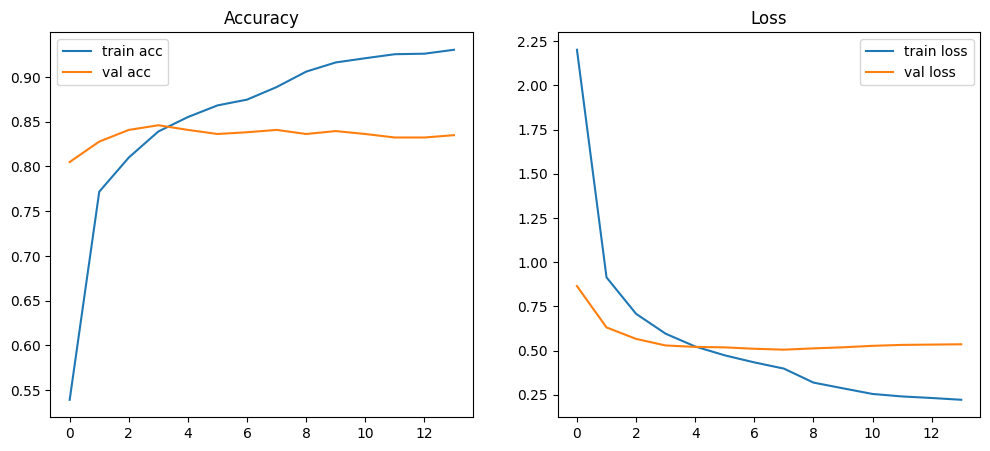

In [ ]:
# =======================
# Dog Breed Identification - ViT+CNN Hybrid (EfficientNetB0 backbone)
# =======================
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -------------------
# Paths
# -------------------
DRIVE_BASE = "/content/drive/MyDrive/DBI"
TRAIN_DIR = os.path.join(DRIVE_BASE, "train")
TEST_DIR  = os.path.join(DRIVE_BASE, "test")

# -------------------
# Config
# -------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 8
EPOCHS_STAGE2 = 20
SEED = 42

# -------------------
# Dataset
# -------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    seed=SEED,
    validation_split=0.15,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    seed=SEED,
    validation_split=0.15,
    subset="validation"
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Detected classes:", NUM_CLASSES)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

# -------------------
# Data augmentation
# -------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -------------------
# Build Model
# -------------------
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False   # Stage 1: freeze backbone

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# -------------------
# Stage 1 Training
# -------------------
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🔹 Stage 1: Training new classifier head")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1
)

# -------------------
# Stage 2 Fine-tuning
# -------------------
base_model.trainable = True   # unfreeze backbone

# Freeze BatchNorm (for stability)
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # smaller LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🔹 Stage 2: Fine-tuning entire model")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, verbose=1),
        keras.callbacks.ModelCheckpoint(
            os.path.join(DRIVE_BASE, "best_model.h5"),
            save_best_only=True,
            monitor="val_accuracy"
        )
    ]
)

# -------------------
# Plot history
# -------------------
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label="train acc")
    plt.plot(val_acc, label="val acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(loss, label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history1, history2)


In [ ]:
# ================================================================
# DBI — EfficientNetV2-B2 (260px) + MixUp + label smoothing
# - Progressive FT (head -> partial -> all)
# - AdamW + CosineDecay, mixed precision
# - Class weights preserved (label_mode='int')
# ================================================================
import os, math, glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

# ---------- Config ----------
IMAGE_SIZE = 260           # EfnV2-B2 default ~260
BATCH_SIZE = 32            # T4: drop to 24/16 if OOM
VAL_SPLIT  = 0.15
SEED       = 1337

HEAD_EPOCHS = 8
FT1_EPOCHS  = 6
FT2_EPOCHS  = 12

BASE_LR = 3e-4
WD      = 1e-5
LABEL_SMOOTH = 0.05
MIXUP_ALPHA = 0.2          # set 0.0 to disable MixUp

# ---------- Env ----------
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision:", mixed_precision.global_policy())

# ---------- Data ----------
AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True, validation_split=VAL_SPLIT, subset='training', seed=SEED
)
val_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False, validation_split=VAL_SPLIT, subset='validation', seed=SEED
)

class_names = train_raw.class_names
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES)

# class weights
counts = []
for c in class_names:
    p = os.path.join(TRAIN_DIR, c)
    counts.append(len(glob.glob(os.path.join(p, "*.*"))))
counts = np.asarray(counts)
counts[counts==0] = 1
class_weight = {i: (counts.sum() / (len(counts) * counts[i])) for i in range(len(counts))}
print("Class weight sample:", list(class_weight.items())[:5])

# Augmentations
norm = layers.Rescaling(1./255)
geom = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.12),
])

def map_train(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    x = geom(x, training=True)
    return tf.cast(x, tf.float32), y

def map_val(x, y):
    return norm(x), y

train_ds = train_raw.map(map_train, num_parallel_calls=AUTOTUNE)
val_ds   = val_raw.map(map_val,   num_parallel_calls=AUTOTUNE)

# Optional MixUp (works with int labels by converting to one-hot on the fly)
def mixup(ds, alpha=MIXUP_ALPHA):
    if alpha <= 0: return ds
    def _map(images, labels):
        # labels -> one-hot
        labels_oh = tf.one_hot(labels, NUM_CLASSES, dtype=tf.float32)
        batch_size = tf.shape(images)[0]
        # shuffle
        idx = tf.random.shuffle(tf.range(batch_size))
        images2 = tf.gather(images, idx, axis=0)
        labels2 = tf.gather(labels_oh, idx, axis=0)
        # lambda beta
        lam = tf.squeeze(tf.random.beta([1], alpha, alpha))
        images_m = lam*tf.cast(images, tf.float32) + (1.0-lam)*tf.cast(images2, tf.float32)
        labels_m = lam*labels_oh + (1.0-lam)*labels2
        return tf.cast(images_m, images.dtype), labels_m
    return ds.map(_map, num_parallel_calls=AUTOTUNE)

train_mix = mixup(train_ds)
train_mix = train_mix.prefetch(AUTOTUNE)
val_ds    = val_ds.prefetch(AUTOTUNE)

# ---------- Model ----------
def build_model(num_classes=NUM_CLASSES):
    base = tf.keras.applications.EfficientNetV2B2(
        include_top=False, weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    base.trainable = False
    inp = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(768, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    logits = layers.Dense(num_classes)(x)
    out = layers.Activation('softmax', dtype='float32')(logits)
    model = keras.Model(inp, out)
    return model, base

model, backbone = build_model()
model.summary()

# losses (handle MixUp vs vanilla)
if MIXUP_ALPHA > 0:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
else:
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)

def make_opt(lr):  # AdamW + weight decay
    return optimizers.AdamW(learning_rate=lr, weight_decay=WD, global_clipnorm=1.0)

# callbacks
best_ckpt = os.path.join(CKPT_DIR, "best.keras")
log_csv   = os.path.join(CKPT_DIR, "train_log.csv")
cbs = [
    callbacks.ModelCheckpoint(best_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.CSVLogger(log_csv, append=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
]

# ---------- Stage 1: head ----------
print("\n🔹 Stage 1: head-only")
model.compile(optimizer=make_opt(BASE_LR), loss=loss_fn,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3) if MIXUP_ALPHA>0
                       else tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
model.fit(
    train_mix, validation_data=val_ds,
    epochs=HEAD_EPOCHS, class_weight=None if MIXUP_ALPHA>0 else class_weight,
    callbacks=cbs, verbose=1
)

# ---------- Stage 2: unfreeze top 40% ----------
print("\n🔹 Stage 2: fine-tune top 40%")
backbone.trainable = True
freeze_until = int(len(backbone.layers) * 0.60)  # freeze bottom 60%
for l in backbone.layers[:freeze_until]:
    l.trainable = False

steps_per_epoch = len(train_raw)
lr_sched = optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
                                            decay_steps=FT1_EPOCHS*steps_per_epoch, alpha=0.1)
model.compile(optimizer=optimizers.AdamW(learning_rate=lr_sched, weight_decay=WD, global_clipnorm=1.0),
              loss=loss_fn,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3) if MIXUP_ALPHA>0
                       else tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
model.fit(
    train_mix, validation_data=val_ds,
    epochs=FT1_EPOCHS, class_weight=None if MIXUP_ALPHA>0 else class_weight,
    callbacks=cbs, verbose=1
)

# ---------- Stage 3: unfreeze all ----------
print("\n🔹 Stage 3: fine-tune ALL (very low LR)")
for l in backbone.layers:
    l.trainable = True

lr_sched2 = optimizers.schedules.CosineDecay(initial_learning_rate=5e-5,
                                             decay_steps=FT2_EPOCHS*steps_per_epoch, alpha=0.2)
model.compile(optimizer=optimizers.AdamW(learning_rate=lr_sched2, weight_decay=WD, global_clipnorm=1.0),
              loss=loss_fn,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3) if MIXUP_ALPHA>0
                       else tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
history = model.fit(
    train_mix, validation_data=val_ds,
    epochs=FT2_EPOCHS, class_weight=None if MIXUP_ALPHA>0 else class_weight,
    callbacks=cbs, verbose=1
)

# Save final
print("\nSaving:", FINAL_MODEL)
model.save(FINAL_MODEL)
print("DONE.")


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision: <DTypePolicy "mixed_float16">


NotFoundError: Could not find directory /content/drive/MyDrive/DBI/train

In [ ]:
# Remove anything inside /content/drive
!rm -rf /content/drive

# Recreate empty folder
!mkdir -p /content/drive

# Now mount cleanly
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls -l /content/drive/MyDrive/DBI


total 74425
-rw------- 1 root root 50346488 Aug 17 11:15 best_model.h5
drwx------ 2 root root     4096 Aug 11 18:47 checkpoints
drwx------ 2 root root     4096 Aug  9 11:12 Combine
-rw------- 1 root root   482063 Sep 29  2023 labels.csv
-rw------- 1 root root 23998883 Apr 10  2023 sample_submission.csv
drwx------ 2 root root     4096 Aug  9 11:12 test
-rw------- 1 root root   383212 Apr 10  2023 test.csv
drwx------ 2 root root     4096 Aug  9 11:12 train
-rw------- 1 root root   982941 Apr 10  2023 train.csv
